In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlearn as xl

In [2]:
data = pd.read_csv('data.csv')
data = data.drop(columns=['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])
data = data.sort_values(by=['date_time']) 
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
1390198,2021-09-01 00:02:49.000000,30,596,5236744527665721365,0,0,7,1,0
5041415,2021-09-26 00:00:00.000000,41,29,1834033519797437404,1,3,0,1,0
1442602,2021-09-26 00:00:00.000000,1,188,7416450538971744701,2,2,15,1,0
7232498,2021-09-26 00:00:00.000000,17,52,1832228443297591417,2,2,5,1,0
14938691,2021-09-26 00:00:00.000000,47,73,4180077124914749282,1,4,13,1,0


Самая первая строчка похожа на то, что за 25 дней до старта просто протестировали, что всё работает. Уберем ее:)

In [3]:
data = data[data['date_time'] > '2021-09-02']
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
5041415,2021-09-26 00:00:00.000000,41,29,1834033519797437404,1,3,0,1,0
1442602,2021-09-26 00:00:00.000000,1,188,7416450538971744701,2,2,15,1,0
7232498,2021-09-26 00:00:00.000000,17,52,1832228443297591417,2,2,5,1,0
14938691,2021-09-26 00:00:00.000000,47,73,4180077124914749282,1,4,13,1,0
11536774,2021-09-26 00:00:00.000000,48,266,1459689388363839798,1,0,1,1,0


In [4]:
data.tail()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
10139863,2021-10-02 23:59:59.000000,24,180,1030486855470422958,0,2,6,1,0
5597133,2021-10-02 23:59:59.000000,73,92,5392241310084555538,0,1,0,1,0
8660907,2021-10-02 23:59:59.000000,17,1235,5569517219693927594,0,4,0,1,0
2991997,2021-10-02 23:59:59.000000,1,2,4888551521096100763,0,0,0,1,0
3226555,2021-10-02 23:59:59.000000,74,418,8774465000271096189,0,0,5,1,0


В нашем распоряжении примерно 1 неделя наблюдений. Теперь разумно посмотреть на график кликов от времени (по часам).

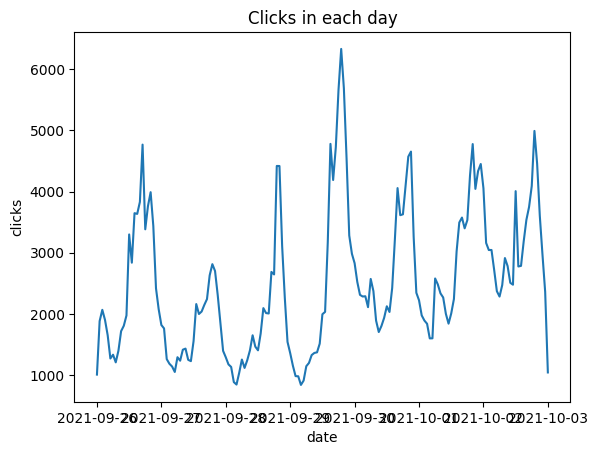

In [13]:
data_for_graphic = data.copy()
data_for_graphic['date_time'] = pd.to_datetime(data_for_graphic['date_time'])
data_for_graphic['date_hour'] = data_for_graphic['date_time'].dt.round("H")
clicks_day = data_for_graphic.groupby('date_hour')['clicks'].sum()


plt.xlabel("date")
plt.ylabel("clicks")
plt.title('Clicks in each day')

plt.plot(clicks_day.index, clicks_day)
plt.show()

Наблюдается повышенная активность примерно в одно и то же время каждый день. + в некоторые дни активность больше (выходные скорее всего). 

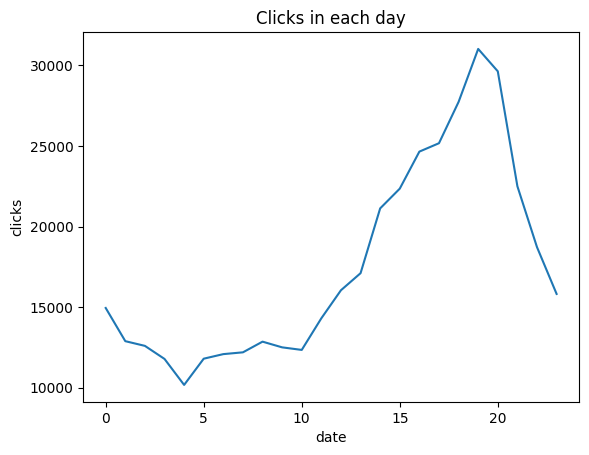

In [14]:
data_for_graphic = data.copy()
data_for_graphic['date_time'] = pd.to_datetime(data_for_graphic['date_time'])
data_for_graphic['date_hour'] = data_for_graphic['date_time'].dt.hour
clicks_day = data_for_graphic.groupby('date_hour')['clicks'].sum()


plt.xlabel("hour")
plt.ylabel("clicks")
plt.title('Clicks in hour')

plt.plot(clicks_day.index, clicks_day)
plt.show()

Если бы данных было бы больше, чем 1 неделя, стоило бы и месяц, и день недели в качестве фичи учитывать. Но тут мы оставляем 2 дня исключительно на тест и валидацию => не набирается даже полной недели. Будем использовать только значение `hour`

In [15]:
# feature engeneering
# + до этого удалена ненужная дата
data['hour'] = pd.to_datetime(data['date_time']).dt.hour

In [16]:
val_day = '2021-10-02'
test_day = '2021-10-03'

Сформируем датасеты

In [17]:
train  = data[(data['date_time']<val_day)]
val = data[(data['date_time']>=val_day) & (data['date_time']<test_day)]
test = data[(data['date_time']>=test_day)]

In [18]:
train.tail()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks,hour
3594598,2021-10-01 23:59:59.000000,254,584,284430210636077854,0,2,10,1,0,23
8604214,2021-10-01 23:59:59.000000,34,47,1801023712706150066,1,2,5,1,0,23
1633515,2021-10-01 23:59:59.000000,3,1239,2731395125248566348,0,2,0,1,0,23
6571049,2021-10-01 23:59:59.000000,139,49,7391999856880902949,0,0,0,1,0,23
6809215,2021-10-01 23:59:59.000000,275,102,2807164680012628209,0,4,1,1,0,23


Теперь преобразуем данные в нужный для libffm формат

In [13]:
cat_features = [(0, 'zone_id'), (1, 'banner_id'), (2, 'oaid_hash'), (3, 'campaign_clicks'), (4, 'os_id'), (5, 'country_id'), (6, 'hour'), (7, 'impressions')]

code = 0
counter_for_libffm = {}
for i, feat in cat_features:
    counter_for_libffm[feat] = {}

def to_ffm_format(filename, data):
    global code
    with open(filename, "w") as file:
        for _, iterrow in data.iterrows():
            for ind, category in cat_features:
                if iterrow[category] not in counter_for_libffm[category]:
                    code += 1
                    counter_for_libffm[category][iterrow[category]] = code
            file.write(str(iterrow['clicks']) + f' {i}:{counter_for_libffm[ind][iterrow[category]]}:1' + '\n')
to_ffm_format("train.txt", train)
to_ffm_format("val.txt", val)
to_ffm_format("test.txt", test)

In [ ]:
for k in range(10, 5, -2):
    for lam in [0.0001, 0.001, 0.01]:
        for lr in [0.01, 0.1]:
            print(f'Параметры: k={k}, lambda={lam}, lr={lr}')
            ffm_model = xl.create_ffm()
            ffm_model.setTrain("train.txt")
            ffm_model.setValidate("val.txt")
            params = {'task':'binary',
                    'metric': 'auc',
                    'lr': lr, 
                    'lambda': lam, 
                    'k': k
            }
            ffm_model.fit(params, 'model.out')
        

Лучше всего получилось при k=10, lr=0.1, lambda=0.0001. Запустим с тестовой

In [3]:
model = xl.create_ffm()
model.setTrain("train.txt")
model.setValidate("val.txt")
model.setTest("test.txt")
param = {'task':'binary',
         'metric':'auc',
         'lr':0.1,
         'lambda':0.0001,
         'k': 10
         }
model.fit(param, 'model.out')

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 20 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516267
[------------] Number of Field: 7
[------------] Time cost for reading problem: 4.56 (sec)
[ ACTION     ] Initialize

# Итого
log_loss=0.123859            auc=0.819454